<a href="https://colab.research.google.com/github/ShimaSama/Netflix-QoS/blob/main/google_colab/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inits

Installing tshark to extract headers from pcap to a csv file

In [1]:
!apt-get install tshark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libc-ares2 libcap2-bin liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpam-cap
  libpcap0.8 libsbc1 libsmi2ldbl libspandsp2 libwireshark-data libwireshark11
  libwiretap8 libwscodecs2 libwsutil9 wireshark-common
Suggested packages:
  mmdb-bin snmp-mibs-downloader wireshark-doc
The following NEW packages will be installed:
  libc-ares2 libcap2-bin liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpam-cap
  libpcap0.8 libsbc1 libsmi2ldbl libspandsp2 libwireshark-data libwireshark11
  libwiretap8 libwscodecs2 libwsutil9 tshark wireshark-common
0 upgraded, 17 newly installed, 0 to remove and 21 not upgraded.
Need to get 16.5 MB of archives.
After this operation, 95.6 MB of additional disk space will be used.
Get:1 

Importing all the libraries that we will need for the project

In [2]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import random
import joblib
import os

Connecting to the google drive shared folders. With this we optimize space and speed as google colab has faster CPU and GPU.

**IMPORTANT: You will need to add a shortcut of MALWIAS into your My Drive folder in order for the project to work**

In [3]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/MALWIAS/TMA/'
MODEL_NAME = 'RandomForest_model_best.sav'

Mounted at /content/drive


## Converting from pcap to csv [skip if not needed]

This part is only done when new pcap files are needed to train or test the model

In [4]:
!tshark -r "/content/drive/My Drive/MALWIAS/TMA/pcap/others1.pcap" -T fields -E header=y -E separator=, -E quote=d -E occurrence=f -e ip.version -e ip.hdr_len  -e ip.id -e ip.flags -e ip.flags.rb -e ip.flags.df -e ip.flags.mf -e ip.frag_offset -e ip.ttl -e ip.proto -e ip.checksum -e ip.len -e ip.dsfield -e tcp.srcport -e tcp.dstport -e tcp.seq -e tcp.ack -e tcp.len -e tcp.hdr_len -e tcp.flags -e tcp.flags.fin -e tcp.flags.syn -e tcp.flags.reset -e tcp.flags.push -e tcp.flags.ack -e tcp.flags.urg -e tcp.flags.cwr -e tcp.window_size -e tcp.checksum -e tcp.urgent_pointer > "/content/drive/My Drive/MALWIAS/TMA/pcap/others1.csv"
!tshark -r "/content/drive/My Drive/MALWIAS/TMA/pcap/netflix1.pcap" -T fields -E header=y -E separator=, -E quote=d -E occurrence=f -e ip.version -e ip.hdr_len  -e ip.id -e ip.flags -e ip.flags.rb -e ip.flags.df -e ip.flags.mf -e ip.frag_offset -e ip.ttl -e ip.proto -e ip.checksum -e ip.len -e ip.dsfield -e tcp.srcport -e tcp.dstport -e tcp.seq -e tcp.ack -e tcp.len -e tcp.hdr_len -e tcp.flags -e tcp.flags.fin -e tcp.flags.syn -e tcp.flags.reset -e tcp.flags.push -e tcp.flags.ack -e tcp.flags.urg -e tcp.flags.cwr -e tcp.window_size -e tcp.checksum -e tcp.urgent_pointer > "/content/drive/My Drive/MALWIAS/TMA/pcap/netflix1.csv"


Running as user "root" and group "root". This could be dangerous.
Running as user "root" and group "root". This could be dangerous.


This is the python part to convert 2 csv to the csv that trains the models

In [5]:
def add_label(file_name, label):
  file = open(BASE_DIR + file_name)
  dataset = pandas.read_csv(file)
  dataset['label'] = label
  return dataset

d1 = add_label('pcap/others1.csv', 'no_netflix')
d2 = add_label('pcap/netflix1.csv', 'netflix')
dataset = pandas.concat([d1, d2])
file = open(BASE_DIR + 'data/retrain2.csv', 'w+')
dataset.to_csv(file, index=False)
file.close()

# Loading dataset

Getting the csv datasets from the pcaps, randomize its rows to improve the training of the ML model and splitting them between training and spliting. Set the number of retrains that are on the google drive and use the same random seed if you are using a loading model.

In [6]:
retrains = 3
seed = 1345 or random.radint(0, 10000)
print('Seed: %s' % seed)

def get_dataset_from_csv(filename, test=False):
  file = open(BASE_DIR + filename, 'r')
  hexa_fields = {item: lambda x: int(x, 16) for item in ["tcp.flags", "tcp.checksum", "ip.checksum", "ip.dsfield", "ip.flags", "ip.id"]}
  dataset = pandas.read_csv(file, converters=hexa_fields)
  if not test:
    datasets = [dataset]
    for x in range(0, retrains):
      file = open(BASE_DIR + 'data/retrain%s.csv' % x, 'r')
      datasets.append(pandas.read_csv(file, converters=hexa_fields))
    print("Got %s datasets" % len(datasets))
    dataset = pandas.concat(datasets).sample(frac=1, random_state=seed).reset_index(drop=True)
  values = dataset.values
  X = values[:,:len(values[1]) - 1]
  Y = values[:,len(values[1]) - 1]
  return X, Y

#X_train, Y_train = get_dataset_from_csv('data/computer.csv')
#X_test, Y_test = get_dataset_from_csv('data/test.csv', test=True)
X, Y = get_dataset_from_csv('data/computer.csv')
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.5, random_state=seed)

Seed: 1345
Got 4 datasets


# Model training

Use this if you want to train a model, if you have a model saved, you can skip this

## Creating model

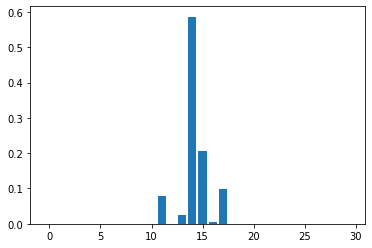

In [7]:
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, Y_train)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

## Saving model

In [10]:
filename = BASE_DIR + 'models/' + MODEL_NAME
joblib.dump(model, filename)

['/content/drive/My Drive/MALWIAS/TMA/models/RandomForest_model_best.sav']

# Model loading

In [6]:
filename = BASE_DIR + 'models/' + MODEL_NAME
model = joblib.load(filename)

# Test & Validation

In [8]:
score = model.score(X_test, Y_test)
expected = Y_test
predicted = model.predict(X_test)

print("Model Score: %s" % score)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Model Score: 0.9757635196320191
              precision    recall  f1-score   support

     netflix       0.92      0.94      0.93     55189
  no_netflix       0.99      0.98      0.99    263958

    accuracy                           0.98    319147
   macro avg       0.96      0.96      0.96    319147
weighted avg       0.98      0.98      0.98    319147

[[ 51668   3521]
 [  4214 259744]]


In [9]:
false_positive = false_negative = true_positive = true_negative = good = 0
for predicted_i, expected_i in zip(predicted, expected):
  if predicted_i == expected_i:
    good += 1
    if predicted_i == "no_netflix":
      true_negative += 1
    else:
      true_positive += 1
  else:
    if predicted_i == "no_netflix":
      false_negative += 1
    else:
      false_positive += 1

print("true positive = " + str(true_positive)+ "---> rate = " + str(true_positive/(true_positive+false_negative)))
print("true negative = " + str(true_negative) + "---> rate = " + str(true_negative/(true_negative+false_positive)))
print("false negative = " + str(false_negative) + "---> rate = " + str(false_negative/(false_negative+true_positive)))
print("false positive = " + str(false_positive) + "---> rate = " + str(false_positive/(false_positive+true_negative)))
print("sensitivity = " + str(true_positive/(true_positive+false_negative)))
print("specifity = " + str(true_negative/(true_negative+false_positive)))
print("acurracy = " + str(good/len(predicted)))

true positive = 51668---> rate = 0.9362010545579735
true negative = 259744---> rate = 0.9840353389554399
false negative = 3521---> rate = 0.0637989454420265
false positive = 4214---> rate = 0.01596466104456012
sensitivity = 0.9362010545579735
specifity = 0.9840353389554399
acurracy = 0.9757635196320191
